<a href="https://colab.research.google.com/github/Extralit/papers-ocr-benchmarks/blob/main/OCR_Benchmark_GPU_Optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Cell 1: Install Dependencies and Setup GPU Environment

# Install required packages
!uv pip install -q "PyMuPDF>=1.23.0" "pandas>=1.5.0" "numpy>=1.21.0"
!uv pip install -q "matplotlib>=3.5.0" "seaborn>=0.11.0" "textdistance>=4.6.0"
!uv pip install -q torch torchvision torchaudio

# Install OCR-specific packages
!uv pip install -q marker-pdf  # Advanced ML-based OCR
!uv pip install -q docling     # IBM's document processing

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


In [2]:
# Cell 2: Import Libraries and GPU Detection

import os
import time
import pandas as pd
import numpy as np
from pathlib import Path
import fitz  # PyMuPDF
import textdistance
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# GPU Detection and Setup
def setup_gpu_environment():
    """Setup GPU environment and return device configuration"""
    device_info = {
        'cuda_available': torch.cuda.is_available(),
        'device_count': 0,
        'device_name': 'CPU',
        'device': 'cpu'
    }

    if torch.cuda.is_available():
        device_info.update({
            'device_count': torch.cuda.device_count(),
            'device_name': torch.cuda.get_device_name(0),
            'device': 'cuda',
            'cuda_version': torch.version.cuda,
            'memory_total': torch.cuda.get_device_properties(0).total_memory / 1e9,
            'memory_reserved': torch.cuda.memory_reserved(0) / 1e9,
            'memory_allocated': torch.cuda.memory_allocated(0) / 1e9
        })

        print("🚀 GPU ACCELERATION ENABLED")
        print(f"   Device: {device_info['device_name']}")
        print(f"   CUDA Version: {device_info['cuda_version']}")
        print(f"   Total Memory: {device_info['memory_total']:.1f} GB")

        # Set optimal GPU settings
        torch.backends.cudnn.benchmark = True
        torch.cuda.empty_cache()
    else:
        print("⚠️  GPU not available - using CPU")
        print("   For GPU acceleration, ensure CUDA is properly installed")

    return device_info

# Initialize GPU environment
device_info = setup_gpu_environment()

print("\n🚀 OCR BENCHMARK FOR SCIENTIFIC LITERATURE - GPU OPTIMIZED")
print("=" * 70)
print("Comparing 3 OCR Systems: Docling, Marker, PyMuPDF")
print("Dataset: Scientific papers from ./pdfs directory")
print(f"Compute Device: {device_info['device_name']}")
print("=" * 70)

🚀 GPU ACCELERATION ENABLED
   Device: Tesla T4
   CUDA Version: 12.6
   Total Memory: 15.8 GB

🚀 OCR BENCHMARK FOR SCIENTIFIC LITERATURE - GPU OPTIMIZED
Comparing 3 OCR Systems: Docling, Marker, PyMuPDF
Dataset: Scientific papers from ./pdfs directory
Compute Device: Tesla T4


In [3]:
# Cell 3: GPU-Optimized OCR System Classes

class GPUOptimizedOCRSystem:
    """GPU-optimized OCR system with automatic device detection"""
    def __init__(self, name, device_info):
        self.name = name
        self.processing_time = 0
        self.device_info = device_info
        self.device = device_info['device']
        self.initialize()

    def initialize(self):
        """Initialize the OCR system with GPU optimization"""
        if self.name == "Docling":
            from docling.document_converter import DocumentConverter

            # GPU-optimized Docling configuration
            if self.device_info['cuda_available']:
                # Configure for GPU if available
                self.converter = DocumentConverter()
                print(f"✅ {self.name} initialized with GPU acceleration")
            else:
                self.converter = DocumentConverter()
                print(f"✅ {self.name} initialized (CPU mode)")

        elif self.name == "Marker":
            from marker.converters.pdf import PdfConverter
            from marker.models import create_model_dict

            # GPU-optimized Marker configuration
            if self.device_info['cuda_available']:
                # Force GPU usage for Marker models
                os.environ['CUDA_VISIBLE_DEVICES'] = '0'
                model_dict = create_model_dict()
                self.converter = PdfConverter(
                    artifact_dict=model_dict,
                    processor_list=None,
                    renderer=None
                )
                print(f"✅ {self.name} initialized with GPU acceleration")
            else:
                model_dict = create_model_dict()
                self.converter = PdfConverter(
                    artifact_dict=model_dict,
                    processor_list=None,
                    renderer=None
                )
                print(f"✅ {self.name} initialized (CPU mode)")

        elif self.name == "PyMuPDF":
            print(f"✅ {self.name} initialized (CPU-based)")

    def extract_text(self, pdf_path):
        """Extract text from PDF with GPU optimization"""
        start_time = time.time()

        # Clear GPU cache before processing
        if self.device_info['cuda_available']:
            torch.cuda.empty_cache()

        try:
            if self.name == "Docling":
                result = self.converter.convert(str(pdf_path))
                text = result.document.export_to_markdown()

            elif self.name == "Marker":
                document = self.converter(str(pdf_path))
                # Handle different Marker API versions
                if hasattr(document, 'render'):
                    text = document.render()
                elif hasattr(document, 'markdown'):
                    text = document.markdown
                else:
                    text = str(document)

            elif self.name == "PyMuPDF":
                doc = fitz.open(str(pdf_path))
                text = ""
                for page_num in range(len(doc)):
                    page = doc.load_page(page_num)
                    text += f"\n=== Page {page_num + 1} ===\n{page.get_text()}\n"
                doc.close()

            self.processing_time = time.time() - start_time

            # Log GPU memory usage if available
            if self.device_info['cuda_available']:
                memory_used = torch.cuda.memory_allocated(0) / 1e9
                print(f"    🔥 GPU Memory Used: {memory_used:.2f} GB")

            return text, {
                'status': 'success',
                'processing_time': self.processing_time,
                'device': self.device,
                'gpu_memory_used': torch.cuda.memory_allocated(0) / 1e9 if self.device_info['cuda_available'] else 0
            }

        except Exception as e:
            self.processing_time = time.time() - start_time
            print(f"    ❌ {self.name} error: {str(e)}")
            return f"Error: {str(e)}", {
                'status': 'error',
                'processing_time': self.processing_time,
                'device': self.device,
                'error': str(e)
            }
        finally:
            # Clean up GPU memory
            if self.device_info['cuda_available']:
                torch.cuda.empty_cache()

print("✅ GPU-Optimized OCR System Classes defined")

✅ GPU-Optimized OCR System Classes defined


In [4]:
# Cell 4: Enhanced Evaluation Metrics

def calculate_text_metrics(reference_text, candidate_text):
    """Calculate comprehensive text comparison metrics"""
    if not reference_text or not candidate_text:
        return {
            'character_accuracy': 0.0,
            'word_accuracy': 0.0,
            'length_ratio': 0.0,
            'word_count_ratio': 0.0,
            'line_count_ratio': 0.0
        }

    # Clean texts
    ref_clean = re.sub(r'\s+', ' ', reference_text.strip())
    cand_clean = re.sub(r'\s+', ' ', candidate_text.strip())

    # Character-level accuracy using Levenshtein distance
    char_distance = textdistance.levenshtein(ref_clean, cand_clean)
    max_len = max(len(ref_clean), len(cand_clean))
    char_accuracy = 1 - (char_distance / max_len) if max_len > 0 else 1.0

    # Word-level accuracy
    ref_words = reference_text.lower().split()
    cand_words = candidate_text.lower().split()

    if ref_words:
        word_distance = textdistance.levenshtein(ref_words, cand_words)
        word_accuracy = 1 - (word_distance / max(len(ref_words), len(cand_words)))
    else:
        word_accuracy = 1.0 if not cand_words else 0.0

    # Additional metrics
    length_ratio = len(candidate_text) / len(reference_text) if len(reference_text) > 0 else 0.0
    word_count_ratio = len(cand_words) / len(ref_words) if len(ref_words) > 0 else 0.0

    ref_lines = len(reference_text.split('\n'))
    cand_lines = len(candidate_text.split('\n'))
    line_count_ratio = cand_lines / ref_lines if ref_lines > 0 else 0.0

    return {
        'character_accuracy': max(0.0, char_accuracy),
        'word_accuracy': max(0.0, word_accuracy),
        'length_ratio': length_ratio,
        'word_count_ratio': word_count_ratio,
        'line_count_ratio': line_count_ratio
    }

def analyze_scientific_content(text):
    """Analyze scientific content preservation with enhanced patterns"""
    # Enhanced patterns for scientific content
    equations = len(re.findall(r'\$.*?\$|\\\(.*?\\\)|\\\[.*?\\\]|\\begin\{equation\}.*?\\end\{equation\}', text, re.DOTALL))
    citations = len(re.findall(r'\[[\d,\s-]+\]|\(\w+\s+et\s+al\.?,?\s+\d{4}\)|\(\w+,?\s+\d{4}\)', text))
    figures = len(re.findall(r'[Ff]igure\s+\d+|[Ff]ig\.?\s+\d+|Figure\s+[A-Z]', text))
    tables = len(re.findall(r'[Tt]able\s+\d+|Table\s+[A-Z]', text))
    formulas = len(re.findall(r'[A-Za-z]+\s*=\s*[A-Za-z0-9\+\-\*/\(\)]+', text))

    return {
        'equations_count': equations,
        'citations_count': citations,
        'figures_count': figures,
        'tables_count': tables,
        'formulas_count': formulas,
        'total_scientific_elements': equations + citations + figures + tables + formulas
    }

print("✅ Enhanced evaluation metrics functions defined")

✅ Enhanced evaluation metrics functions defined


In [5]:
# Cell 5: GPU-Optimized Benchmark Runner

def run_gpu_optimized_benchmark():
    """Run the complete OCR benchmark with GPU optimization"""

    # Initialize GPU-optimized OCR systems
    systems = {
        'Docling': GPUOptimizedOCRSystem('Docling', device_info),
        'Marker': GPUOptimizedOCRSystem('Marker', device_info),
        'PyMuPDF': GPUOptimizedOCRSystem('PyMuPDF', device_info)
    }

    # Find PDFs
    pdf_dir = Path('./pdfs')
    pdf_files = list(pdf_dir.glob('*.pdf'))

    if not pdf_files:
        print("❌ No PDFs found in ./pdfs directory!")
        return None, None

    print(f"\n📚 Found {len(pdf_files)} PDFs:")
    for pdf in pdf_files:
        print(f"  • {pdf.name}")

    # Create output directory in results folder
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = Path(f"./results/gpu_benchmark_{timestamp}")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Also ensure main results directory exists
    Path("./results").mkdir(exist_ok=True)

    # Log system information
    system_info_file = output_dir / 'system_info.txt'
    with open(system_info_file, 'w') as f:
        f.write("GPU-Optimized OCR Benchmark System Information\n")
        f.write("=" * 50 + "\n")
        f.write(f"Timestamp: {datetime.now()}\n")
        f.write(f"CUDA Available: {device_info['cuda_available']}\n")
        f.write(f"Device: {device_info['device_name']}\n")
        if device_info['cuda_available']:
            f.write(f"CUDA Version: {device_info['cuda_version']}\n")
            f.write(f"GPU Memory: {device_info['memory_total']:.1f} GB\n")
        f.write(f"PyTorch Version: {torch.__version__}\n")

    # Run extractions with GPU monitoring
    all_extractions = {}

    for pdf_path in pdf_files:
        pdf_name = pdf_path.stem
        print(f"\n📖 Processing: {pdf_name}")
        print("-" * 60)

        extractions = {}

        for system_name, system in systems.items():
            print(f"🔄 {system_name}...")

            # Monitor GPU memory before processing
            if device_info['cuda_available']:
                memory_before = torch.cuda.memory_allocated(0) / 1e9
                print(f"    📊 GPU Memory Before: {memory_before:.2f} GB")

            text, metadata = system.extract_text(pdf_path)

            # Save extracted text with metadata
            output_file = output_dir / f"{pdf_name}_{system_name}.txt"
            with open(output_file, 'w', encoding='utf-8') as f:
                f.write(f"OCR System: {system_name}\n")
                f.write(f"PDF: {pdf_name}\n")
                f.write(f"Processing Time: {metadata.get('processing_time', 0):.2f}s\n")
                f.write(f"Device: {metadata.get('device', 'unknown')}\n")
                f.write(f"GPU Memory Used: {metadata.get('gpu_memory_used', 0):.2f} GB\n")
                f.write(f"Status: {metadata.get('status', 'unknown')}\n")
                f.write("=" * 60 + "\n\n")
                f.write(text)

            extractions[system_name] = {
                'text': text,
                'metadata': metadata
            }

            print(f"    ⏱️  Time: {metadata.get('processing_time', 0):.2f}s")
            print(f"    📝 Length: {len(text):,} chars")
            print(f"    💾 Saved: {output_file.name}")

        all_extractions[pdf_name] = extractions

    return all_extractions, output_dir

print("✅ GPU-optimized benchmark runner function defined")

✅ GPU-optimized benchmark runner function defined


In [7]:
# Cell 9: Download PDFs from GitHub

!git clone https://github.com/Extralit/papers-ocr-benchmarks.git /tmp/papers-ocr-benchmarks
!mkdir -p ./pdfs
!cp /tmp/papers-ocr-benchmarks/pdfs/* ./pdfs/
!rm -rf /tmp/papers-ocr-benchmarks

print("✅ PDFs downloaded to ./pdfs directory!")

Cloning into '/tmp/papers-ocr-benchmarks'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 77 (delta 30), reused 67 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (77/77), 2.27 MiB | 23.99 MiB/s, done.
Resolving deltas: 100% (30/30), done.
✅ PDFs downloaded to ./pdfs directory!


In [8]:
# Cell 6: Run the GPU-Optimized Benchmark

print("🚀 Starting GPU-Optimized OCR Benchmark...")
extractions, output_dir = run_gpu_optimized_benchmark()

if extractions:
    print(f"\n✅ Benchmark completed!")
    print(f"📁 Results saved to: {output_dir}")
else:
    print("❌ Benchmark failed!")

🚀 Starting GPU-Optimized OCR Benchmark...
✅ Docling initialized with GPU acceleration
✅ Marker initialized with GPU acceleration
✅ PyMuPDF initialized (CPU-based)

📚 Found 3 PDFs:
  • Allossogbe_et_al_2017_Mal_J.pdf
  • Somboon_et_al_1995_Trans_RSTMH.pdf
  • 2014-Combining_organophosphate_treated_wall_linings_and_long-lasting_insecticidal_nets_for_improved_control_of_pyrethroi.pdf

📖 Processing: Allossogbe_et_al_2017_Mal_J
------------------------------------------------------------
🔄 Docling...
    📊 GPU Memory Before: 2.46 GB


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


    🔥 GPU Memory Used: 2.97 GB
    ⏱️  Time: 35.12s
    📝 Length: 53,171 chars
    💾 Saved: Allossogbe_et_al_2017_Mal_J_Docling.txt
🔄 Marker...
    📊 GPU Memory Before: 2.97 GB


Running OCR Error Detection: 100%|██████████| 1/1 [00:00<00:00, 26.21it/s]
Detecting bboxes: 0it [00:00, ?it/s]
Detecting bboxes: 0it [00:00, ?it/s]
Recognizing tables: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


    🔥 GPU Memory Used: 2.99 GB
    ⏱️  Time: 8.58s
    📝 Length: 54,803 chars
    💾 Saved: Allossogbe_et_al_2017_Mal_J_Marker.txt
🔄 PyMuPDF...
    📊 GPU Memory Before: 2.99 GB
    🔥 GPU Memory Used: 2.99 GB
    ⏱️  Time: 0.21s
    📝 Length: 46,345 chars
    💾 Saved: Allossogbe_et_al_2017_Mal_J_PyMuPDF.txt

📖 Processing: Somboon_et_al_1995_Trans_RSTMH
------------------------------------------------------------
🔄 Docling...
    📊 GPU Memory Before: 2.99 GB
    🔥 GPU Memory Used: 2.99 GB
    ⏱️  Time: 82.26s
    📝 Length: 43,194 chars
    💾 Saved: Somboon_et_al_1995_Trans_RSTMH_Docling.txt
🔄 Marker...
    📊 GPU Memory Before: 2.99 GB


Running OCR Error Detection: 100%|██████████| 1/1 [00:00<00:00, 36.27it/s]
Detecting bboxes: 0it [00:00, ?it/s]
Detecting bboxes: 0it [00:00, ?it/s]
Recognizing tables: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


    🔥 GPU Memory Used: 2.99 GB
    ⏱️  Time: 6.16s
    📝 Length: 41,318 chars
    💾 Saved: Somboon_et_al_1995_Trans_RSTMH_Marker.txt
🔄 PyMuPDF...
    📊 GPU Memory Before: 2.99 GB
    🔥 GPU Memory Used: 2.99 GB
    ⏱️  Time: 0.04s
    📝 Length: 41,276 chars
    💾 Saved: Somboon_et_al_1995_Trans_RSTMH_PyMuPDF.txt

📖 Processing: 2014-Combining_organophosphate_treated_wall_linings_and_long-lasting_insecticidal_nets_for_improved_control_of_pyrethroi
------------------------------------------------------------
🔄 Docling...
    📊 GPU Memory Before: 2.99 GB
    🔥 GPU Memory Used: 2.99 GB
    ⏱️  Time: 19.29s
    📝 Length: 61,550 chars
    💾 Saved: 2014-Combining_organophosphate_treated_wall_linings_and_long-lasting_insecticidal_nets_for_improved_control_of_pyrethroi_Docling.txt
🔄 Marker...
    📊 GPU Memory Before: 2.99 GB


Running OCR Error Detection: 100%|██████████| 1/1 [00:00<00:00, 29.70it/s]
Detecting bboxes: 0it [00:00, ?it/s]
Recognizing Text: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
Detecting bboxes: 0it [00:00, ?it/s]
Recognizing tables: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


    🔥 GPU Memory Used: 3.01 GB
    ⏱️  Time: 8.19s
    📝 Length: 60,054 chars
    💾 Saved: 2014-Combining_organophosphate_treated_wall_linings_and_long-lasting_insecticidal_nets_for_improved_control_of_pyrethroi_Marker.txt
🔄 PyMuPDF...
    📊 GPU Memory Before: 3.01 GB
    🔥 GPU Memory Used: 3.01 GB
    ⏱️  Time: 0.04s
    📝 Length: 52,363 chars
    💾 Saved: 2014-Combining_organophosphate_treated_wall_linings_and_long-lasting_insecticidal_nets_for_improved_control_of_pyrethroi_PyMuPDF.txt

✅ Benchmark completed!
📁 Results saved to: results/gpu_benchmark_20250703_055218


In [13]:
!cat /content/results/gpu_benchmark_20250703_055218/Somboon_et_al_1995_Trans_RSTMH_PyMuPDF.txt

OCR System: PyMuPDF
PDF: Somboon_et_al_1995_Trans_RSTMH
Processing Time: 0.04s
Device: cuda
GPU Memory Used: 2.99 GB
Status: success


=== Page 1 ===
248 
TRANSACTIONS 
OF THE ROYAL SOCIETY OF TROPICAL MEDICINE AND HYGIENE (1995) 89, 248-254 
Entomological 
evaluation 
of community-wide 
use of lambdacyhalothrin- 
impregnated 
bed nets against 
malaria 
in a border area of north-west 
Thailand 
Pradya Somboon’, Jo Lines2, Apinun Aramrattana3, Udom Chitprarop4, Somsak Prajakwong4 and Chirasak 
Khamboonrua& 
‘Department of Parasitology, Faculty of Medicine, Chiang Mai University, Chiang Mai 50200, 
Thailand; 2Department of Medical Parasitology, London School of Hygiene and Tropical Medicine, Keppel Street, London, 
WCIE 
7HT, UK; 3Department of Family Medicine, Faculty of Medicine, Chiang Mai University, Chiang Mai 50200, 
Thailand; 4Malaria Centre, Region 2, Chiang Mai 50200, Thailand; SResearch Institute for Health Sciences, Chiang Mai 
University, Chiang Mai 50200, Thailand 
Abstract 

In [14]:
# Cell 7: Enhanced Metrics Calculation

def calculate_enhanced_metrics(extractions):
    """Calculate enhanced comparison metrics with GPU performance data"""

    results = []

    for pdf_name, pdf_extractions in extractions.items():
        if 'PyMuPDF' not in pdf_extractions:
            continue

        baseline_text = pdf_extractions['PyMuPDF']['text']
        baseline_scientific = analyze_scientific_content(baseline_text)

        for system_name, extraction in pdf_extractions.items():
            if system_name == 'PyMuPDF':
                continue  # Skip baseline comparison with itself

            if extraction['metadata']['status'] != 'success':
                continue

            # Text comparison metrics
            text_metrics = calculate_text_metrics(baseline_text, extraction['text'])

            # Scientific content analysis
            scientific_metrics = analyze_scientific_content(extraction['text'])

            result = {
                'PDF': pdf_name,
                'System': system_name,
                'Character_Accuracy': text_metrics['character_accuracy'],
                'Word_Accuracy': text_metrics['word_accuracy'],
                'Length_Ratio': text_metrics['length_ratio'],
                'Word_Count_Ratio': text_metrics['word_count_ratio'],
                'Processing_Time': extraction['metadata']['processing_time'],
                'Text_Length': len(extraction['text']),
                'Device': extraction['metadata'].get('device', 'unknown'),
                'GPU_Memory_Used': extraction['metadata'].get('gpu_memory_used', 0),
                'Equations_Found': scientific_metrics['equations_count'],
                'Citations_Found': scientific_metrics['citations_count'],
                'Figures_Found': scientific_metrics['figures_count'],
                'Tables_Found': scientific_metrics['tables_count'],
                'Formulas_Found': scientific_metrics['formulas_count'],
                'Scientific_Elements_Total': scientific_metrics['total_scientific_elements'],
                'Status': extraction['metadata']['status']
            }

            results.append(result)

    return pd.DataFrame(results)

# Calculate enhanced metrics
if extractions:
    results_df = calculate_enhanced_metrics(extractions)

    # Save results
    results_file = output_dir / 'gpu_benchmark_results.csv'
    results_df.to_csv(results_file, index=False)

    # Create enhanced summary with GPU metrics
    summary_df = results_df.groupby('System').agg({
        'Character_Accuracy': ['mean', 'std'],
        'Word_Accuracy': ['mean', 'std'],
        'Processing_Time': ['mean', 'std'],
        'Text_Length': 'mean',
        'GPU_Memory_Used': 'mean',
        'Scientific_Elements_Total': 'mean'
    }).round(3)

    summary_file = output_dir / 'gpu_benchmark_summary.csv'
    summary_df.to_csv(summary_file)

    # Copy latest results to main results folder
    import shutil
    main_results_dir = Path("./results")
    shutil.copy2(results_file, main_results_dir / "latest_benchmark_results.csv")
    shutil.copy2(summary_file, main_results_dir / "latest_benchmark_summary.csv")

    print("💾 Files saved:")
    print(f"  📄 Detailed results: {results_file}")
    print(f"  📊 Summary: {summary_file}")
    print(f"  🖥️  System info: {output_dir / 'system_info.txt'}")
    print(f"  📋 Latest results also copied to: ./results/latest_benchmark_*.csv")

💾 Files saved:
  📄 Detailed results: results/gpu_benchmark_20250703_055218/gpu_benchmark_results.csv
  📊 Summary: results/gpu_benchmark_20250703_055218/gpu_benchmark_summary.csv
  🖥️  System info: results/gpu_benchmark_20250703_055218/system_info.txt
  📋 Latest results also copied to: ./results/latest_benchmark_*.csv


📊 GPU-OPTIMIZED BENCHMARK RESULTS


,PDF,System,Character_Accuracy,Word_Accuracy,Length_Ratio,Word_Count_Ratio,Processing_Time,Text_Length,Device,GPU_Memory_Used,Equations_Found,Citations_Found,Figures_Found,Tables_Found,Formulas_Found,Scientific_Elements_Total,Status
0,Allossogbe_et_al_2017_Mal_J,Docling,0.818706,0.701115,1.147287,1.047733,35.123128,53171,cuda,2.965459,0,32,12,14,0,58,success
1,Allossogbe_et_al_2017_Mal_J,Marker,0.777607,0.697241,1.182501,1.036187,8.580534,54803,cuda,2.987022,11,39,0,3,1,54,success
2,Somboon_et_al_1995_Trans_RSTMH,Docling,0.775622,0.720273,1.046468,0.968109,82.261602,43194,cuda,2.987022,3,7,6,7,5,28,success
3,Somboon_et_al_1995_Trans_RSTMH,Marker,0.868682,0.809567,1.001018,0.968717,6.155208,41318,cuda,2.989021,3,4,5,7,5,24,success
4,2014-Combining_organophosphate_treated_wall_li...,Docling,0.844456,0.755238,1.175448,1.069417,19.289043,61550,cuda,2.989021,0,31,12,21,11,75,success
5,2014-Combining_organophosphate_treated_wall_li...,Marker,0.846334,0.783034,1.146879,1.050686,8.186339,60054,cuda,3.006288,6,29,12,21,11,79,success



📈 SUMMARY STATISTICS


Character_Accuracy        Word_Accuracy        Processing_Time  \
                      mean    std          mean    std            mean   
System                                                                   
Docling              0.813  0.035         0.726  0.027          45.558   
Marker               0.831  0.047         0.763  0.059           7.641   

                Text_Length GPU_Memory_Used Scientific_Elements_Total  
            std        mean            mean                      mean  
System                                                                 
Docling  32.757   52638.333           2.981                    53.667  
Marker    1.301   52058.333           2.994                    52.333

/tmp/ipython-input-15-3235018623.py:41: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-15-3235018623.py:41: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-15-3235018623.py:41: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-15-3235018623.py:41: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1

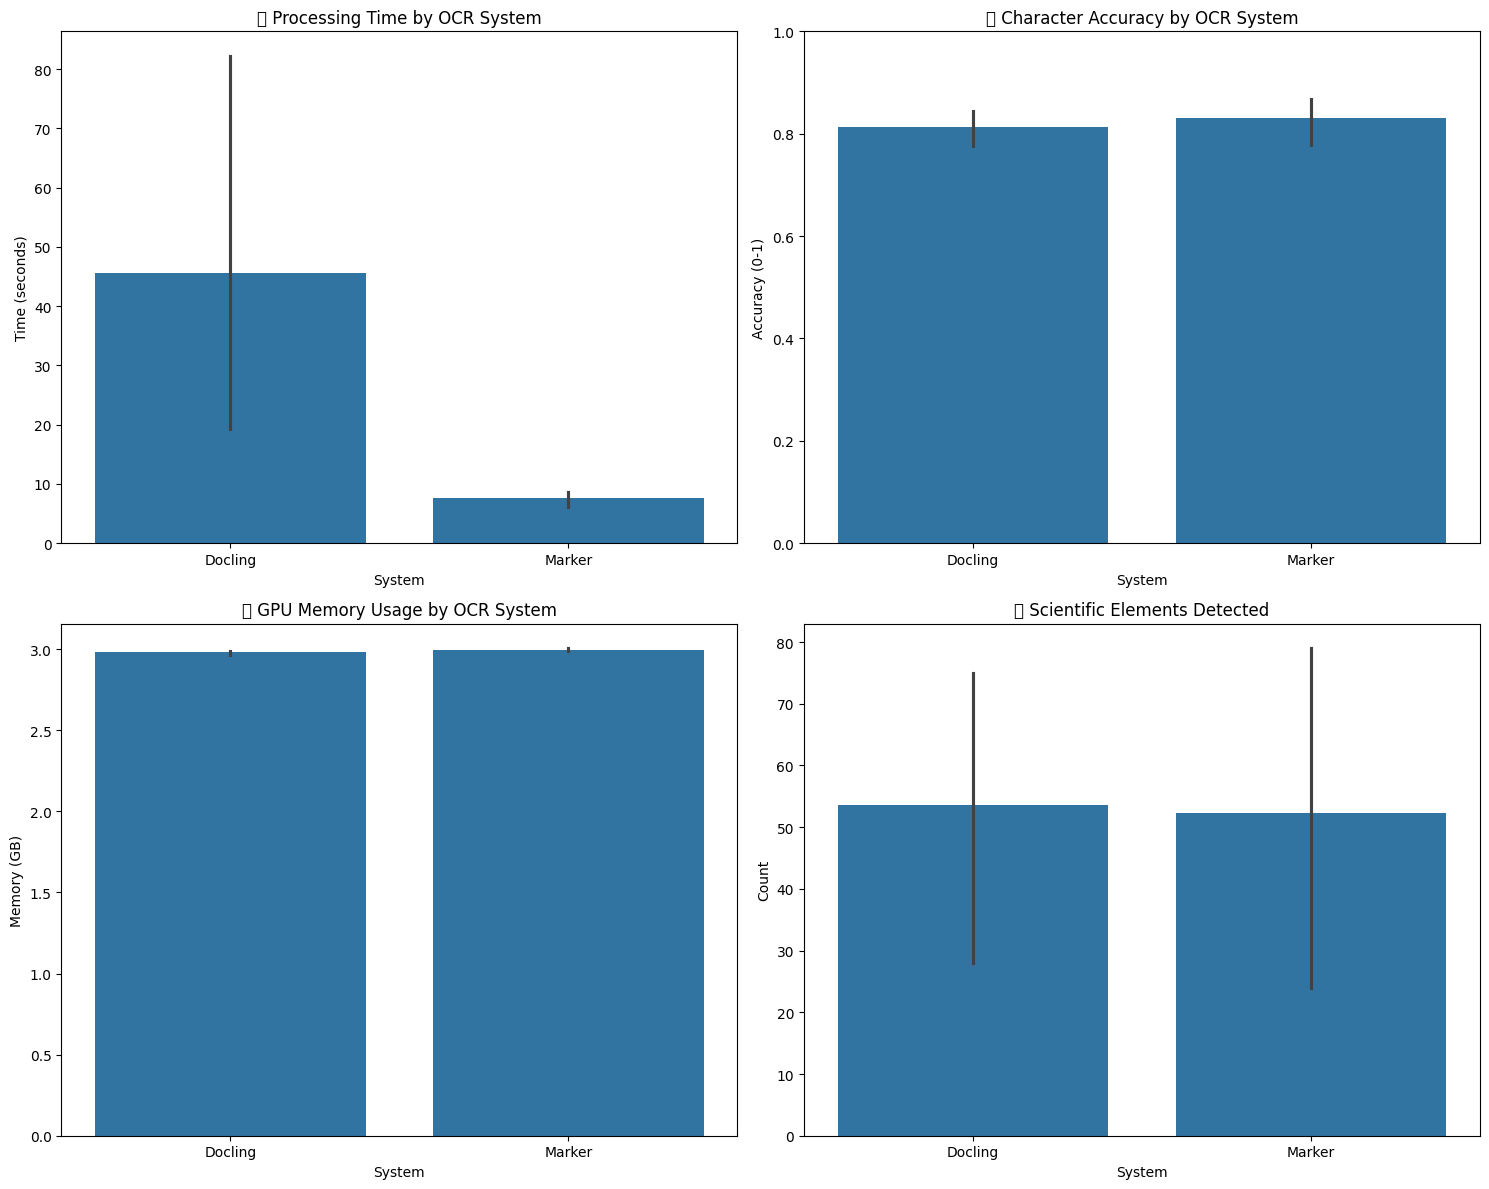

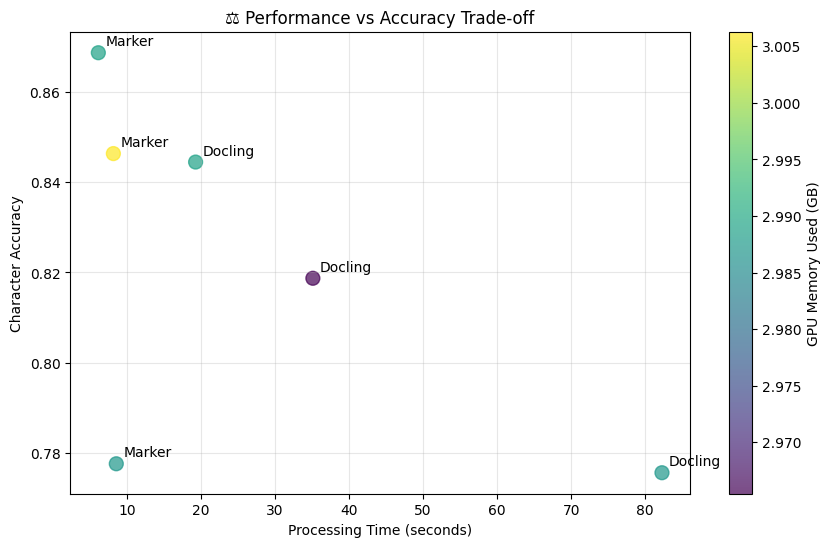

In [15]:
# Cell 8: Display Results and Visualizations

if extractions and not results_df.empty:
    print("📊 GPU-OPTIMIZED BENCHMARK RESULTS")
    print("=" * 70)
    display(results_df)

    print(f"\n📈 SUMMARY STATISTICS")
    print("=" * 70)
    display(summary_df)

    # Create visualizations
    plt.style.use('default')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Processing Time Comparison
    sns.barplot(data=results_df, x='System', y='Processing_Time', ax=ax1)
    ax1.set_title('🚀 Processing Time by OCR System')
    ax1.set_ylabel('Time (seconds)')

    # 2. Character Accuracy Comparison
    sns.barplot(data=results_df, x='System', y='Character_Accuracy', ax=ax2)
    ax2.set_title('📝 Character Accuracy by OCR System')
    ax2.set_ylabel('Accuracy (0-1)')
    ax2.set_ylim(0, 1)

    # 3. GPU Memory Usage
    if device_info['cuda_available']:
        sns.barplot(data=results_df, x='System', y='GPU_Memory_Used', ax=ax3)
        ax3.set_title('🔥 GPU Memory Usage by OCR System')
        ax3.set_ylabel('Memory (GB)')
    else:
        ax3.text(0.5, 0.5, 'GPU Not Available', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('🔥 GPU Memory Usage (Not Available)')

    # 4. Scientific Elements Detection
    sns.barplot(data=results_df, x='System', y='Scientific_Elements_Total', ax=ax4)
    ax4.set_title('🔬 Scientific Elements Detected')
    ax4.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Performance vs Accuracy scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(results_df['Processing_Time'], results_df['Character_Accuracy'],
                         c=results_df['GPU_Memory_Used'], s=100, alpha=0.7, cmap='viridis')

    for i, txt in enumerate(results_df['System']):
        plt.annotate(txt, (results_df['Processing_Time'].iloc[i], results_df['Character_Accuracy'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points')

    plt.xlabel('Processing Time (seconds)')
    plt.ylabel('Character Accuracy')
    plt.title('⚖️ Performance vs Accuracy Trade-off')
    plt.colorbar(scatter, label='GPU Memory Used (GB)')
    plt.grid(True, alpha=0.3)
    plt.show()